<a href="https://colab.research.google.com/github/bayuzen19/Business-Inteligence-Batch-3/blob/main/Day_19_%26_20_Case_Study_A_B_Testing_atau_Uplift_Modelling_bayuzen_ahmad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 1 - A/B Testing
Introduction <br>
Tim marketing sedang membuat teknologi marketing baru berupa iklan yang menyesuaikan dengan data historis pengguna ketika menggunakan platform dan ingin mengetahui seberapa baik performa dari iklan personalisasi ini dengan iklan biasa. Anda ditunjuk oleh tim marketing untuk menjalankan A/B testing untuk menguji hipotesis bahwa landing page yang baru akan meningkatkan konversi.<br>

Task <br>
Lakukan eksplorasi dengan visual dan interpretasi pada data yang diberikan:<br>
Jumlah user per marketing channel <br>
Jumlah user per variant <br>
Jumlah user converted per variant <br>
Jumlah user converted per variant dari waktu ke waktu <br>
Jumlah user converted per age group <br>
Korelasi prefered language dan converted <br>

Lakukan pengujian A/B testing untuk menunjukkan bahwa terdapat perbedaan signifikan berdasarkan jumlah konversi antara iklan baru dengan iklan lama. Perhatikan dengan baik aksi terakhir yang dilakukan tiap user! <br>

Buatlah presentasi berdasarkan hasil riset anda disertai dengan actionable insights/rekomendasi berdasarkan hasil analisis.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import TTestPower, TTestIndPower, GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm

import scipy.stats

In [30]:
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/marketing_campaign_experiment/marketing-clean.csv")

# Data Inspection

In [31]:
df.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,1/18/18,House Ads,False,1
1,a100000041,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,2/22/18,House Ads,False,1
2,a100000042,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,3/9/18,House Ads,False,1
3,a100000043,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,2/18/18,House Ads,False,1
4,a100000044,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,3/3/18,House Ads,False,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              577 non-null    object
 1   date_served          577 non-null    object
 2   marketing_channel    577 non-null    object
 3   variant              577 non-null    object
 4   converted            577 non-null    bool  
 5   language_displayed   577 non-null    object
 6   language_preferred   577 non-null    object
 7   age_group            577 non-null    object
 8   date_subscribed      577 non-null    object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  577 non-null    object
 11  is_retained          577 non-null    bool  
 12  conversion           577 non-null    int64 
dtypes: bool(2), int64(1), object(10)
memory usage: 50.8+ KB


In [33]:
for x in df.columns:
  print(f"================Kolom dari {x}===============")
  print(f"{df[x].unique()}")
  print()

================Kolom dari user_id===============
['a100000040' 'a100000041' 'a100000042' 'a100000043' 'a100000044'
 'a100000045' 'a100000046' 'a100000047' 'a100000048' 'a100000059'
 'a100000060' 'a100000061' 'a100000062' 'a100000063' 'a100000064'
 'a100000065' 'a100000066' 'a100000067' 'a100000088' 'a100000089'
 'a100000090' 'a100000091' 'a100000092' 'a100000093' 'a100000094'
 'a100000095' 'a100000096' 'a100000101' 'a100000102' 'a100000103'
 'a100000104' 'a100000105' 'a100000107' 'a100000108' 'a100000109'
 'a100000110' 'a100000164' 'a100000165' 'a100000166' 'a100000167'
 'a100000168' 'a100000169' 'a100000170' 'a100000171' 'a100000172'
 'a100000260' 'a100000261' 'a100000262' 'a100000263' 'a100000264'
 'a100000265' 'a100000266' 'a100000267' 'a100000268' 'a100000294'
 'a100000295' 'a100000296' 'a100000297' 'a100000298' 'a100000299'
 'a100000300' 'a100000301' 'a100000302' 'a100000317' 'a100000318'
 'a100000319' 'a100000320' 'a100000321' 'a100000322' 'a100000323'
 'a100000324' 'a100000325'

dari data, tipe data telah sesuai kecuali untuk kolom yang bersifat waktu. perlu sedikit modifikasi terhadap format waktu untuk menjadi tipe YYYY-MM-DD

In [34]:
df["date_served"] = pd.to_datetime(df['date_served'],format="%m/%d/%y",infer_datetime_format=True)
df["date_canceled"] = pd.to_datetime(df['date_canceled'],format="%m/%d/%y",infer_datetime_format=True)
df["date_subscribed"] = pd.to_datetime(df['date_subscribed'],format="%m/%d/%y",infer_datetime_format=True)

In [35]:
for x in df.columns:
  print(f"================Kolom dari {x}===============")
  print(f"{df[x].unique()}")
  print()

================Kolom dari user_id===============
['a100000040' 'a100000041' 'a100000042' 'a100000043' 'a100000044'
 'a100000045' 'a100000046' 'a100000047' 'a100000048' 'a100000059'
 'a100000060' 'a100000061' 'a100000062' 'a100000063' 'a100000064'
 'a100000065' 'a100000066' 'a100000067' 'a100000088' 'a100000089'
 'a100000090' 'a100000091' 'a100000092' 'a100000093' 'a100000094'
 'a100000095' 'a100000096' 'a100000101' 'a100000102' 'a100000103'
 'a100000104' 'a100000105' 'a100000107' 'a100000108' 'a100000109'
 'a100000110' 'a100000164' 'a100000165' 'a100000166' 'a100000167'
 'a100000168' 'a100000169' 'a100000170' 'a100000171' 'a100000172'
 'a100000260' 'a100000261' 'a100000262' 'a100000263' 'a100000264'
 'a100000265' 'a100000266' 'a100000267' 'a100000268' 'a100000294'
 'a100000295' 'a100000296' 'a100000297' 'a100000298' 'a100000299'
 'a100000300' 'a100000301' 'a100000302' 'a100000317' 'a100000318'
 'a100000319' 'a100000320' 'a100000321' 'a100000322' 'a100000323'
 'a100000324' 'a100000325'

In [36]:
#remove kolom is retained because just have one value
df = df.drop("is_retained",axis=1)
df.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,conversion
0,a100000040,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-01-18,House Ads,1
1,a100000041,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-02-22,House Ads,1
2,a100000042,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,2018-03-09,House Ads,1
3,a100000043,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-02-18,House Ads,1
4,a100000044,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-03-03,House Ads,1


# Eksploratory Data Analytics

# Jumlah channel user per marketing channel

Text(0, 0.5, 'Marketing Channel')

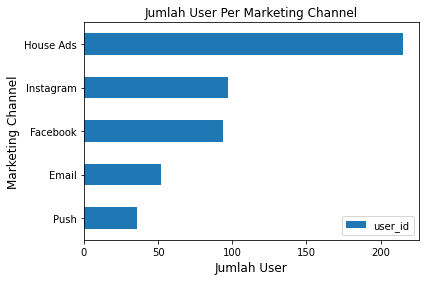

In [37]:
marketing_user = df.groupby("marketing_channel").agg({"user_id":"nunique"})
marketing_user.sort_values("user_id",ascending=True).plot(kind='barh').set_title("Jumlah User Per Marketing Channel",fontsize=12)
plt.xlabel("Jumlah User",fontsize=12)
plt.ylabel("Marketing Channel",fontsize=12)

House Ads memiliki jumlah user terbanyak yaitu sekitar 200 disusul dengan instagram dan facebook sekitar 100 users

In [38]:
df.groupby(["marketing_channel","variant"]).agg({"conversion":['count','sum','mean']})

conversion              
                                       count sum      mean
marketing_channel variant                                 
Email             control                 23  23  1.000000
                  personalization         30  21  0.700000
Facebook          control                 37   5  0.135135
                  personalization         68  66  0.970588
House Ads         control                147  70  0.476190
                  personalization        111  55  0.495495
Instagram         control                 44  11  0.250000
                  personalization         77  73  0.948052
Push              control                 16   3  0.187500
                  personalization         24  22  0.916667

secara convertion by marketing channel terlihat bahwa : <br>
1.Email, Personalization terjadi penurunan convertion rate <br>
2.Facebook, Personalization terjadi peningkatan convertion rate <br>
3.House Ads, perbedaan tidak beda jauh (akan dilakukan uji chi square untuk melihat perbedaan significant secara statistik atau tidak ) <br>
4.Instagram, Personalization terjadi peningkatan convertion rate <br>
5.Push, Personalization terjadi peningkatan convertion rate

In [39]:
#chi square test House ads
Ho="Perbedaan tidak signifikant"
H1= "Perbedaan signifikant"

house_ads = df[df['marketing_channel']=="House Ads"][["variant","conversion"]]
house_ads = pd.crosstab(house_ads["variant"],house_ads["conversion"])

from scipy.stats import chi2_contingency

c, p, dof, expected = chi2_contingency(house_ads)

if p<0.05:
    print(H1,"as p value than 0.05, p value is {}".format(p))
else:
    print(Ho,"as p value more than 0.05, p value is {}".format(p))

Perbedaan tidak signifikant as p value more than 0.05, p value is 0.8560586900716323


ternayata perbedaan tidak signifikant secara statistik antara personalization dan control dari house ads terhadap convertion

## Jumlah User per Variant

Text(0, 0.5, 'variant')

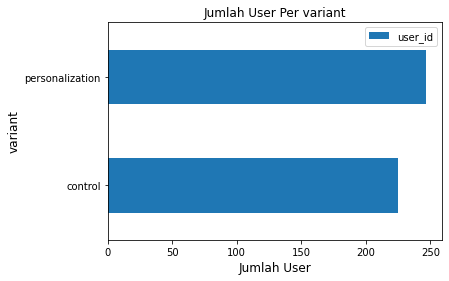

In [40]:
variant_user = df.groupby("variant").agg({"user_id":"nunique"})
variant_user.sort_values("user_id",ascending=True).plot(kind='barh').set_title("Jumlah User Per variant",fontsize=12)
plt.xlabel("Jumlah User",fontsize=12)
plt.ylabel("variant",fontsize=12)

jumlah variant personalization sedikit lebih banyak dibandingkan dengan jumlah user dari control group. data variant dapat dikategorikan tidak imbalance

## Jumlah user converted pervariant

Text(0, 0.5, 'Jumlah User')

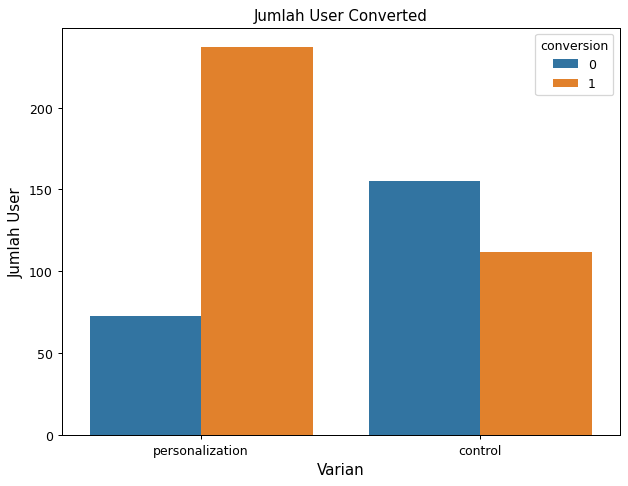

In [41]:
plt.figure(figsize=(8,6),dpi=90)
sns.countplot(data=df,x="variant",hue="conversion").set_title("Jumlah User Converted",fontsize=12)
plt.xlabel("Varian",fontsize=12)
plt.ylabel("Jumlah User",fontsize=12)

ternyata jumlah user yang terkonversi bedasrakan jenis varian adalah personalisation berkisar 237 dibandingkan yang tidak terkonversi berkisar 73 convertion rate sebesar ~76% sedangkan jumlah user terkonversi dari variant control sebesar 112 dan tidak terkonversi sebesar 155 dengan tingkat convertion rate sebesar ~42%

## Jumlah Converted per covariant waktu per waktu

In [42]:
#untuk mencari jumlah konversi dari waktu ke waktu maka dapar menggunakan colom date subscribe untuk mengetahui kapan saja user terkonversi
df["date_subscribed"].unique()

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-30T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28

bulan dan tahun sama, maka kita hanya akan menggunakan tanggalnya saya

Text(0, 0.5, 'Jumlah Conversion')

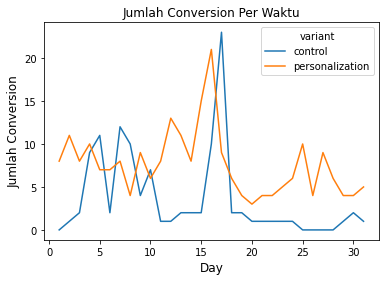

In [43]:
rate_subscribe = df[["date_subscribed","variant","conversion"]].copy()
rate_subscribe['day'] = rate_subscribe["date_subscribed"].dt.day
rate_subscribe = rate_subscribe.groupby(["day","variant"],as_index=False)["conversion"].sum()

#visual
sns.lineplot(data=rate_subscribe,x='day',y="conversion",hue='variant').set_title("Jumlah Conversion Per Waktu",fontsize=12)
plt.xlabel("Day",fontsize=12)
plt.ylabel("Jumlah Conversion",fontsize=12)

seperti yang terlihat terjanya convertion rate per waktu antara kelompok variant memiliki jumlah yang sama tetapi kita dapat mengetahui jumlah konversi yang banyak terjadi di tanggal 15 untuk personalization dan tanggal 16 pada kelompok control

## Jumlah user converted per Age Group

Text(0, 0.5, 'Jumlah')

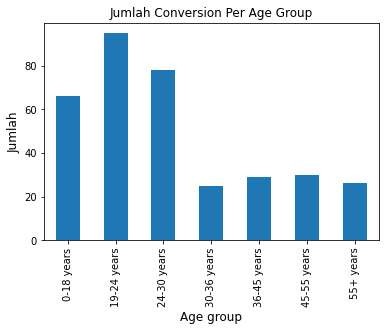

In [44]:
age_conversion = df.groupby("age_group")["conversion"].sum()
age_conversion.plot(kind="bar").set_title("Jumlah Conversion Per Age Group",fontsize=12)
plt.xlabel("Age group",fontsize=12)
plt.ylabel("Jumlah",fontsize=12)

jumlah konversi terbanyak terlihat pada kelompok 19-24 tahun disusul dengan age group 24-30 tahun. secara graofik memberikan kita informasi bahwa kelompok rentang umur muda (batasan umur 0-30 tahun) sangat banyak yang terkonversi dan ini dapat menjadi target yang bagus

Text(0, 0.5, 'Jumlah')

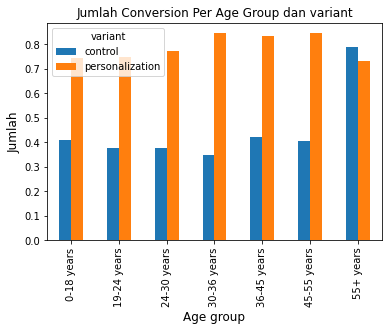

In [45]:
age_conversion = df.groupby(["age_group","variant"])["conversion"].mean().unstack()
age_conversion.plot(kind="bar").set_title("Jumlah Conversion Per Age Group dan variant",fontsize=12)
plt.xlabel("Age group",fontsize=12)
plt.ylabel("Jumlah",fontsize=12)

ternyata iklan baru hanya memiliki konvertion rate yang tinggi dari kelompok umur kecuali kelompok umur diatas 55 tahun

## Korelasi prefered language dan converted

In [46]:
df.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,conversion
0,a100000040,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-01-18,House Ads,1
1,a100000041,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-02-22,House Ads,1
2,a100000042,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,2018-03-09,House Ads,1
3,a100000043,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-02-18,House Ads,1
4,a100000044,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-03-03,House Ads,1


In [47]:
import scipy.stats as stats
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers = []
for i in df.select_dtypes(exclude = 'number').columns:
    cramers.append(cramers_v(df['conversion'], df[i]))
res = pd.DataFrame(data = [df.select_dtypes(exclude = 'number').columns, cramers] 
             ).T 
res.columns = ['Column', 'Cramers_V']
res.sort_values(by = 'Cramers_V', ascending = False).reset_index(drop = True)

,Column,Cramers_V
0,converted,0.996368
1,date_served,0.428197
2,variant,0.346151
3,subscribing_channel,0.244291
4,marketing_channel,0.225294
5,language_preferred,0.151012
6,age_group,0.123154
7,language_displayed,0.122098
8,user_id,0.0
9,date_subscribed,0.0


ternyata effect dari language preferred secara cramers'v memiliki effect sebesar 0.15

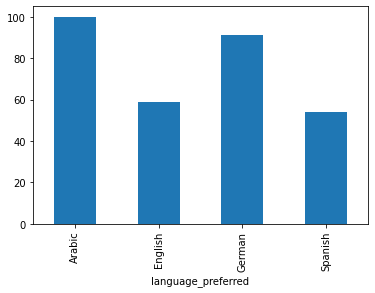

In [48]:
(df.groupby("language_preferred")["conversion"].mean()*100).plot(kind="bar")

In [49]:
pd.pivot_table(df,index='language_preferred',columns="language_displayed",values="conversion",aggfunc="mean").fillna(0)

language_displayed,Arabic,English,German,Spanish
language_preferred,,,,
Arabic,1.0,1.000000,0.0,0.0
English,0.0,0.587669,0.0,0.0
German,0.0,1.000000,0.9,0.0
Spanish,0.0,0.600000,0.0,0.5


kita juga mengetuhui bahwa meskipun customer memiliki language preferred selain inggris, tetapi dengan menampilkan dengan bahasa inggris dalam ads conversi tetap besar, hal ini dapat dilihat dari german,spanish dan arab. Hal ini wajar karena bahasa inggris adalah bahasa international

# A/B testing

H0 : Tidak terdapat perbedaan signifikant antara iklan lama dan iklan baru <br>
H1 : Terdapat perbedaan signifikant antara iklan lama dan iklan baru

In [50]:
conv_calculation = df.groupby(
    ['variant', 'conversion'], as_index = False
).size().pivot(
    index='variant', columns = "conversion", values = "size"
).reset_index().assign(
    conv_percent = lambda x: x[True] * 100 / (x[True] + x[False])
).assign(
    total_sample = lambda x: x[True] + x[False]
)

In [51]:
conv_calculation

conversion,variant,0,1,conv_percent,total_sample
0,control,155,112,41.947566,267
1,personalization,73,237,76.451613,310


In [52]:
conv_control = conv_calculation[conv_calculation['variant'] == 'control']['conv_percent'].values
conv_personalization = conv_calculation[conv_calculation['variant'] == 'personalization']['conv_percent'].values

In [53]:
(conv_personalization - conv_control)*100/conv_control

array([82.25518433])

ternyata ada effect peningkatan sebesar 82% dengan menggunakan iklan baru dibandingkan dengan iklan lama

In [54]:
# find number of succession
success = conv_calculation[['total_sample', True]].values[:,1]
# find number of all observations
obs = conv_calculation[['total_sample', True]].values[:,0]

In [55]:
result = proportions_chisquare(success, obs)

In [56]:
# Calculate chi squared result
print('X-squared: %.3f' % result[0])
print('p-value: %.3f' % result[1])

X-squared: 71.454
p-value: 0.000


dari hasil kita mengetahui bahwa : <br>
1.peningkatan konversi secara iklan baru sebesar 82% dengan perbandingan iklan lama hanya mengkonversi sebesar ~42% sedangkan iklan baru mengkonversi sebesar ~76%. <br>
2.uplift 82% relative terhadap perbandingan konversi iklan baru dengan iklan lama. <br>
3.karena p-value < 0.05 maka hyphotesis bahwa iklan baru lebih efektif dapat diterima (H1)

# rekomendasi

1.Iklan baru memberikan dampak terhadap konvertion rate tetapi dari analisis menunjukkan bahwa tidak semua marketing channel yang diberikan iklan baru memiliki dampak seperti marketing channel : house_ads dan email. <br>
2.marketing channel yang dapat dioptimisasi dengan iklan baru adalah marketing channel push, instagram dan facebook. <br>
3.tetap tampilkan iklan dalam bentuk bahasa inggris meskip bahasa preferred bukan bahasa inggris karena secara konvertion masih bagus dan dapat menghemat biaya karena tidak perlu menyewa jasa transalator. <br>
4.karena perbedaan begitu signifikant antara iklan baru dan iklan lama antara kelompok umur kecuali kelompok umur diatas 55 tahun, jadi kita dapat mentreat semua kelompok umur dengan iklan baru